# Preliminary

We read in the dataset and try to understand the data.  We also draft a tentative approach for the modelling exercise.

In [1]:
import numpy as np
import pandas as pd
import logging
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
# utf-8-sig
encoding = "latin1"
filepath = "D:\CognoRise Intern\shopper_sentiment\shopper_dataset\TeePublic_review.csv"
with open(filepath, encoding=encoding, errors='replace') as file:
    shopdf = pd.read_csv(file, encoding=encoding)


In [3]:
shopdf

,reviewer_id,store_location,latitude,longitude,date,month,year,title,review,review-label
0,0.0,US,37.090240,-95.712891,2023,6,2015 00:00:00,Great help with lost order,I had an order that was lost in transit. When ...,5
1,1.0,US,37.090240,-95.712891,2023,6,2024 00:00:00,I ordered the wrong size tee and hadï¿½ï¿½ï¿½,I ordered the wrong size tee and had difficult...,5
2,2.0,US,37.090240,-95.712891,2023,6,2017 00:00:00,These guys offer the best customerï¿½ï¿½ï¿½,These guys offer the best customer service in ...,5
3,3.0,US,37.090240,-95.712891,2023,6,2024 00:00:00,Good Stuff,Looked for an obscure phrase on a shirt. Teepu...,5
4,4.0,CA,56.130366,-106.346771,2023,6,2023 00:00:00,My order arrived in a good timelyï¿½ï¿½ï¿½,My order arrived in a good timely fashion & th...,4
...,...,...,...,...,...,...,...,...,...,...
278095,278095.0,US,37.090240,-95.712891,2018,4,2027 00:00:00,Highly recommend!,"Delivery is quick, arrives when promised. Shir...",5
278096,278096.0,HR,45.100000,15.200000,2018,4,2027 00:00:00,Great quality,"Great quality, fast delivery, would recommend!",5
278097,278097.0,US,37.090240,-95.712891,2018,4,2027 00:00:00,Dudes rock.,Dudes rock. Seriously.,5
278098,278098.0,US,37.090240,-95.712891,2018,4,2027 00:00:00,Shipping was fast the T-shirt was justï¿½ï¿½ï¿½,Shipping was fast the T-shirt was just right g...,5


## Helper functions

**The dataset has non-ascii characters that need to be cleaned.**  The review text seems to have 'floating' type embedded making
it _impossible_ to use a single function on the entire text.  The answer is to examine each document (piece of review) for it 
being a string and only then encode it to ascii; it is replaced with a '?' character otherwise.

Below, we code a function to lower-case, tokenize, remove stopwords and stem our text.

In [4]:

import nltk
from nltk.corpus import stopwords
 
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anasafira\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Stemming and Tokenization

We use split() instead of tokenize().

In [5]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
# Helper function to remove non-ascii chars and for stemming.

def remove_non_ascii(text): # Gets the full document in the row
    if type(text) == str:
        #cl_text = ' '.join([stemmer.stem(w.lower()) for w in text.split() if ((type(w) == str) and (w.lower() not in stopwords))])
        cl_text = ' '.join([w.lower() for w in text.split() if ((type(w) == str) and (w.lower() not in stopwords))]) 

        return cl_text.encode('ascii', 'ignore').decode('ascii')
    else: # Probably non-ASCII such as float that has crept in
        return('?')

**Below, we lower-case and stem our words in the documents**

In [6]:
shopdf['review'] = shopdf['review'].map(remove_non_ascii)


## Class Distribution
We check for the imbalance of the target label.

<Axes: xlabel='review-label', ylabel='count'>

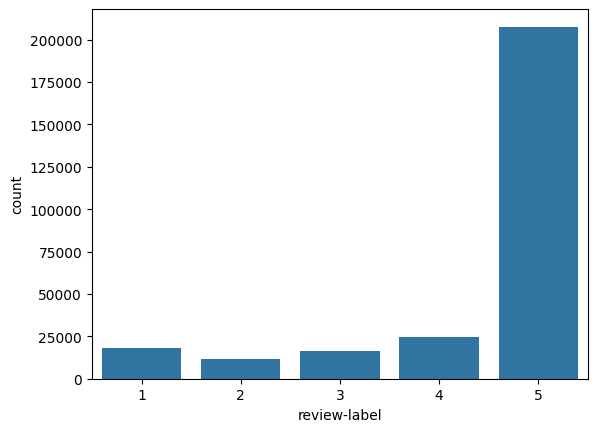

In [7]:
sns.countplot(data=shopdf, x='review-label')

In [8]:
print(list(shopdf))

['reviewer_id', 'store_location', 'latitude', 'longitude', 'date', 'month', 'year', 'title', 'review', 'review-label']


We drop the unnecessary columns. 

In [9]:
col_selection =  shopdf[['review', 'review-label']]


In [10]:
col_selection.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278100 entries, 0 to 278099
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   review        278100 non-null  object
 1   review-label  278100 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 4.2+ MB


In [11]:
(col_selection.dropna()
 .isnull()
 .sum())

review          0
review-label    0
dtype: int64

In [12]:
col_selection.head()

,review,review-label
0,order lost transit. called help customer servi...,5
1,ordered wrong size tee difficulties returning ...,5
2,guys offer best customer service retail! produ...,5
3,looked obscure phrase shirt. teepublic it. pro...,5
4,order arrived good timely fashion & items rece...,4


In [13]:
# If 'review-label' is less than 4, the label will be 'bad experience', otherwise it will be 'happy'
col_selection['label'] = col_selection['review-label'].apply(lambda x: 'bad experience' if x < 4 else 'happy')

# Display the DataFrame with the new 'label' column
print(col_selection[['review', 'label']])

                                                   review           label
0       order lost transit. called help customer servi...           happy
1       ordered wrong size tee difficulties returning ...           happy
2       guys offer best customer service retail! produ...           happy
3       looked obscure phrase shirt. teepublic it. pro...           happy
4       order arrived good timely fashion & items rece...           happy
...                                                   ...             ...
278095  delivery quick, arrives promised. shirts quali...           happy
278096     great quality, fast delivery, would recommend!           happy
278097                             dudes rock. seriously.           happy
278098  shipping fast t-shirt right good company suici...           happy
278099  print shirt blurry appeared faded. thegraphic ...  bad experience

[278100 rows x 2 columns]


C:\Users\anasafira\AppData\Local\Temp\ipykernel_35072\3379802320.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col_selection['label'] = col_selection['review-label'].apply(lambda x: 'bad experience' if x < 4 else 'happy')


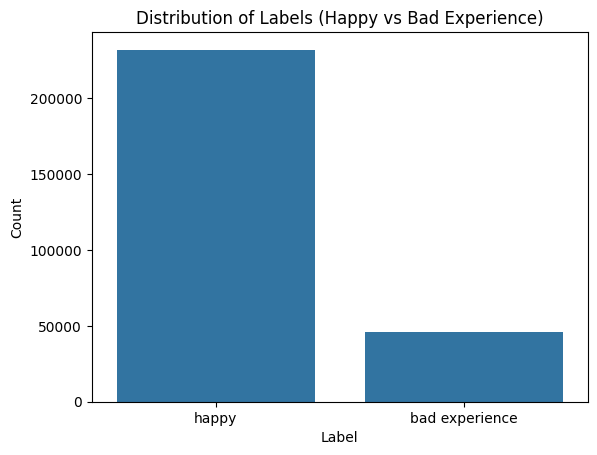

In [14]:
# Plotting the distribution of the 'label' column
sns.countplot(data=col_selection, x='label')

# Adding title and labels to the plot for better clarity
plt.title('Distribution of Labels (Happy vs Bad Experience)')
plt.xlabel('Label')
plt.ylabel('Count')

# Display the plot
plt.show()

## X,y Definition

We use just the `review` column for our modelling.

In [15]:
X = col_selection['review']      # shopdf.iloc[:,:-1]
y = col_selection['label']     # shopdf.iloc[:,-1:]

## Train Test Split

In [16]:
from sklearn.model_selection import train_test_split

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y, random_state=1)

# EDA

Let us now divert our attention to some EDA.  We will try to glean some insight for our data prep and modelling
pipeline.

## Wordcloud

There is a lot of noise in the text which the stopwords doesn't seem to remove.  We will impose an additional
condition of word length while making the word cloud.

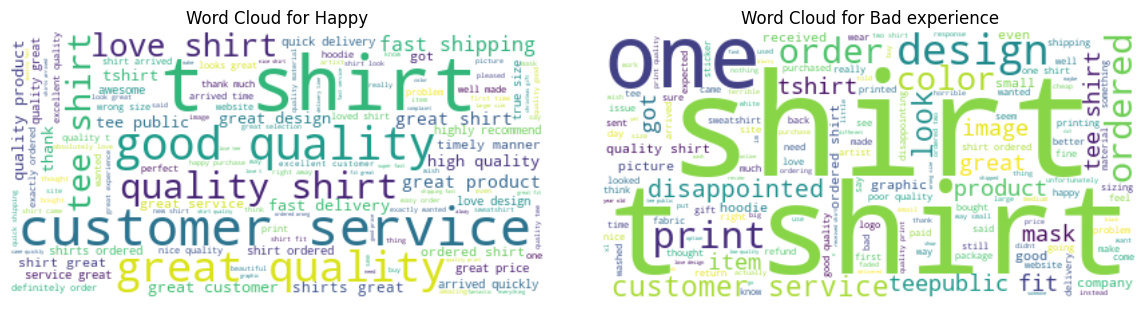

In [17]:
# Create subplots for the visualizations
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plt.tight_layout()

# Flat list of axes to iterate over
ax = axes.flat

# Iterate over the unique values in the 'label' column (i.e., 'bad experience' and 'happy')
for i, cat in enumerate(col_selection['label'].unique()[:]):
    # Aggregate text for each label
    try:
        # Join all reviews where the label is 'cat' (either 'bad experience' or 'happy')
        label_text = ' '.join([w for w in col_selection[col_selection['label'] == cat]['review'].values])
        
        # Generate word cloud for the aggregated reviews
        wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white').generate(label_text)
        
        # Display the word cloud
        ax[i].imshow(wordcloud, interpolation='bilinear')
        ax[i].set_title(f'Word Cloud for {cat.capitalize()}')
        ax[i].axis('off')  # Hide axes for clarity
    except Exception as e:
        print(f"Error processing category {cat}: {e}")


In [18]:
tfidf = TfidfVectorizer()
tfidf.fit(X_train)

TfidfVectorizer()

In [19]:
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

## Model Section

C:\Users\anasafira\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


                precision    recall  f1-score   support

bad experience       0.83      0.73      0.78      9205
         happy       0.95      0.97      0.96     46415

      accuracy                           0.93     55620
     macro avg       0.89      0.85      0.87     55620
  weighted avg       0.93      0.93      0.93     55620



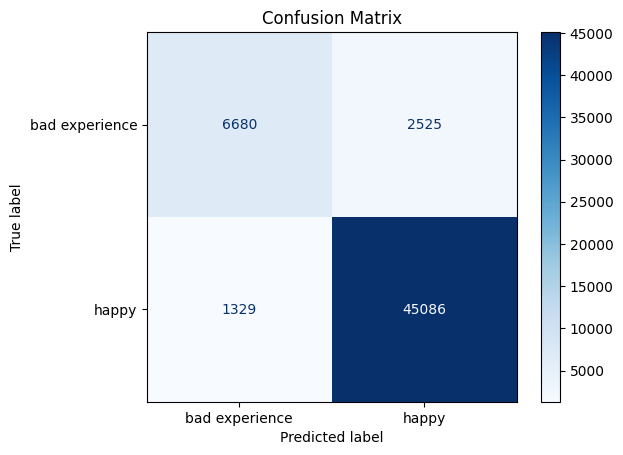

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt

# Definisikan fungsi untuk melatih model, membuat prediksi, dan mencetak laporan
def report(model, X_train_tfidf, y_train, X_test_tfidf, y_test):
    # Latih model dan buat prediksi
    model.fit(X_train_tfidf, y_train)
    preds = model.predict(X_test_tfidf)
    
    # Cetak classification report
    print(classification_report(y_test, preds))
    
    # Hitung confusion matrix
    conf_matrix = confusion_matrix(y_test, preds)
    
    # Tampilkan confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

# Inisialisasi model LinearSVC
lvc = LinearSVC(max_iter=1000)

# Panggil fungsi report dengan model LinearSVC
report(lvc, X_train_tfidf, y_train, X_test_tfidf, y_test)


## TESTING

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

pipe = Pipeline([('tfidf', TfidfVectorizer()), 
                 ('svc', LinearSVC())])

pipe.fit(X, y)  # Fit model
data = pipe.predict(X)  # Predict

C:\Users\anasafira\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [28]:
col_selection['predictions'] = data
col_selection.sample(25)

C:\Users\anasafira\AppData\Local\Temp\ipykernel_35072\4092961499.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col_selection['predictions'] = data


,review,review-label,label,predictions
117922,bought shirt grandson's birthday. fit perfect....,5,happy,happy
212191,?,5,happy,happy
47671,great quality shirts. mine perfect,5,happy,happy
238597,"great quality, loving it!",5,happy,happy
245472,?,5,happy,happy
70592,needed replacement tees taken care pronto - ki...,5,happy,happy
259031,?,3,bad experience,happy
60863,?,5,happy,happy
269574,"everything good happy product, shipping long t...",4,happy,happy
121323,love teepublic. birthday christmas whatever oc...,5,happy,happy
